In [1]:
from IPython.display import Image

## General Form

Chapter 7 of ISL describes increasing our model complexity beyond simple, linear regression. We can add some complexity to our fit if we design our fit scheme to consider polynomial fits or step functions.

Generically though, we can express our linear form as

$y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2(x_i) + \beta_3 b_3(x_i) + ... + \beta_K b_K(x_i) + \epsilon_i$

Where all of these `beta` terms are some fixed, arbitrary functions. Each term can be anything-- polynomial, step, whatever.

## Expanding

### Piecewise Polynomial

Taking it a step further, they discuss a blend of the two called *piecewise polynomials*, which are defined by "knots"-- the points where we split our polynomial regression. For example, if we wanted to construct two degree-3 polynomials with a knot at the point `c`, we'd have

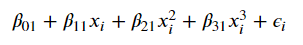

In [2]:
Image('images/piecewise_1.PNG')

when `x` is less than `c`, and

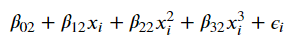

In [3]:
Image('images/piecewise_2.PNG')

otherwise. By design, all of the `beta` coefficients differ between the two equations, and which equation we use depends on where our `x` value falls relative to `c`.

This leads us to a model that might look like this

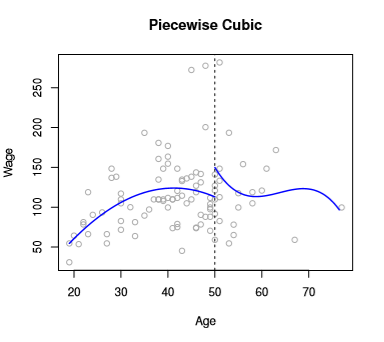

In [4]:


Image('images/fig_7_3_topleft.PNG')

From a Degrees of Freedom perspective, we end up having to *sum* the degrees of freedom for the two equations to find our Degrees of Freedom for our predictor. Here, we have a total of 8.

Obviously, this leads to an erratic-looking prediction curve. We correct this by introducing constraints on continuity. Refitting might yield something like

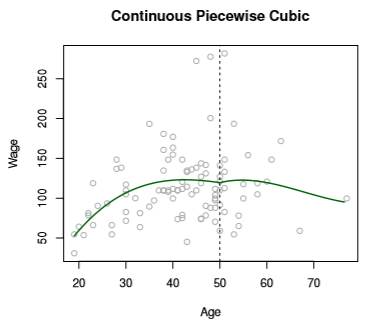

In [5]:
Image('images/fig_7_3_topright.PNG')

If we further constrained that our prediction curve must *look smooth*, we'd have

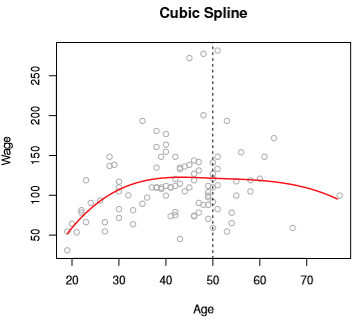

In [6]:
Image('images/fig_7_3_bottomleft.PNG')

But how do we actually *do* that?

### Spline Functions

Turns out we basically just rewrite the basis model

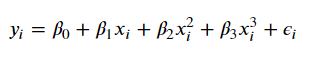

In [7]:
Image('images/basis.PNG')

But then "add one *truncated power basis* function, `h(x, xi)`, per knot", which is defined as

$h(x, \xi) = (x - \xi)^3_+$

which takes on its value where `x > xi`, or `0` otherwise ([similar to our ReLU activation function, employed in Deep Learning contexts](https://napsterinblue.github.io/notes/machine_learning/neural_nets/activation_fns/))

Introducing one of these `h(x, xi)` terms for every knot gives us the convenient property of continuous first and second derivatives everywhere except the point `x = xi`, which is why we only consider values greater than `xi`, the knots

To tie it all together, if we wanted to write a cubic polynomial with 3 knots, we'd have

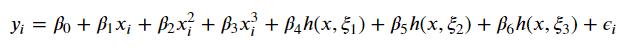

In [8]:
Image('images/basis_w_splines.PNG')

which has 7 degrees of freedom. Compare this to the stepwise/polynomial approach which would have had 16!


#### Boundary Constraints

It's worth also mentioning that in practice, we also often add "boundary constraints" to enforce smoothness at the extremes.

If you look at the chart below, you can see that the error bands of Cubic Spline as-is have wonky behavior on the far left and right of the function.

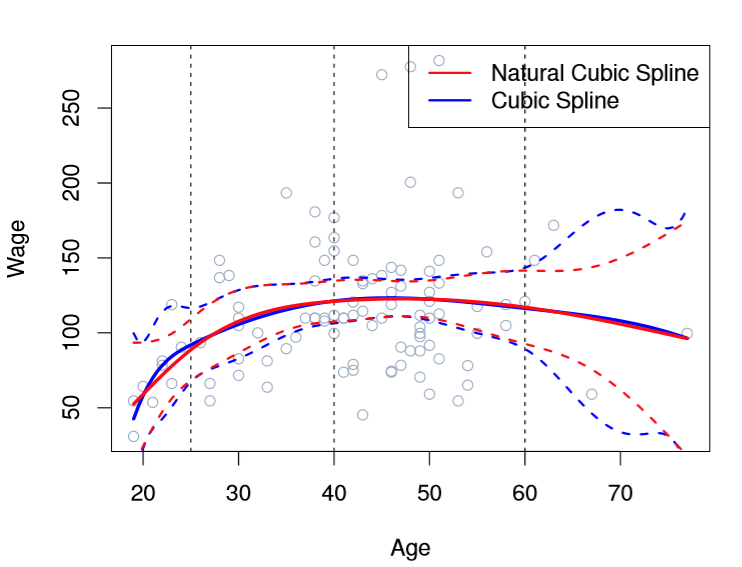

In [9]:
Image('images/fig_7_4.PNG')

So in addition to our `h(x, xi)` continuity constraints, we also require that `X` has a linear first derivative for values greater than the greatest knot and smaller than the smallest. This winds up meaning *fewer* effective degrees of freedom and thus smoother end-behavior.

For less hand-waving over the mechanics of actually making that happen, we basically follow [this problem-solving form](https://www.youtube.com/watch?v=gT7F3TWihvk) with the added derivative constrants on the ends.

#### Knot Selection

Of course, this leads us to two hyperparameters to consider, both of which having straight-foward solutions.

Where should the knots go?

- ISL advocates for just selecting the desired Degrees of Freedom (and by extension, the number of knots) and letting Computers™ figure it out. This typically yields knots spread evenly over percentiles.

How many knots should we use?

- Like many similar questions of this nature, ISL punts to investigation via Cross Validation

#### Vs High-Degree Polynomial

We could have effectively fit the data above using a complicated polynomial (the book uses Degree 15) like so

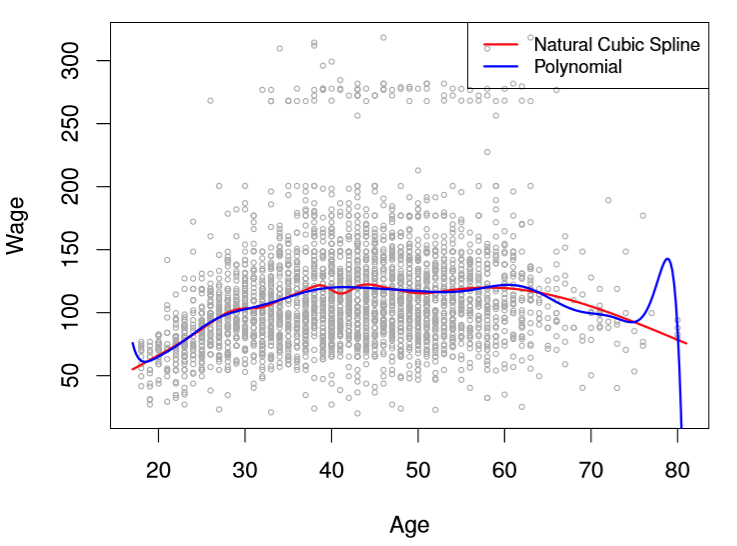

In [10]:
Image('images/fig_7_7.PNG')

But the real value of using Splines is clear as day when you consider the points on the extremes.

Think about it-- if your fringe data yields bigger error than points closer to the means (where Splines evidently predict pretty well), would you rather have your data cubed, or to the power of 15?

By fixing our degree to cubic and utilizing knots to localize fits in trouble areas, we enjoy the flexibility of high-degree polynomials, but control for some of the prediction error messiness that they introduce.

### Smoothing Splines

If you squint, the last section was basically "use knots to increase the expressiveness of polynomial functions, but make sure they're smooth." Expanding on this last part, suppose we had a magic, perfectly-accurate function `g(x)`, whose loss function would be the familiar

$RSS = \sum_{i=1}^n (y_i - g(x_i))^2$

If we fit this perfect `g(x)`, our RSS would be zero, but plotting the predictions would be this erratic, spikey mess of hitting every point perfectly-- obviously doomed to overfit.

Thus (like Lasso and Ridge regression) we can layer in a penalizing term that leverages a tuning parameter `lambda` like so

$\sum_{i=1}^n (y_i - g(x_i))^2 + \lambda \int g''(t)^2 dt$

where the last term, the second derivative, is basically a "measure of roughness" and is large when `g(t)` is wiggly near a point `t`.

Considering the values `lambda` can take on, we have two extremes:

- `lambda = 0`: This gives us our original jumpy line
- `lambda` is huge: This pushes `g'(x)` to zero and basically gives us a straight line.

Surprisingly, due to Math™, this magical `g(x)` function that minimizes our new loss function is actually a natural cubic spline with knots at each value of `X`, `x1, x2, ..., xn`.

#### Effective Degrees of Freedom

Looking at this, two things jumped out at me. `n` knot terms means `n` additional `h(x, xi)` terms in our `y` which is:

- Probably computationally expensive to fit
- An inordinately high Degree of Freedom

Apparently, this `lambda` term is so poweful that it crimps the roughness of these splines, and thereby the *Effective Degrees of Freedom*. Additionally, due to some very elegant/convenient Math™, because we're using all terms `x1, x2, ..., xn` in our calculation, we can basically forego calculating each term of Leave-One-Out Cross Validation and instead use the following ([snipped from these slides](https://web.stanford.edu/class/stats202/content/lec17-cond.pdf))

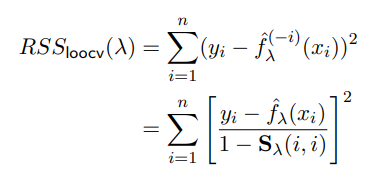

In [11]:
Image('images/rss_cv.PNG')

Few notes:

- We used `g`, they used `f`
- The `^(-i)` "exponent" the top means the fitted value of `xi` on a spline fit on every value *except* `xi`
- ISL states (for which there is a formula) for their construction of `S` and so will we.

### Local Regression

Moving along, Local Regression basically adapts the idea of KNN to the regression setting.

Essentially, we fit a separate model for each new `x0` by:

- Choosing a *span* parameter, `s`, representing the proportion of training points nearest `x0`
- Weight each of our points selected by `s` relative to their distance from `x0` (the bell curves below)
- Pick your regression scheme (they did linear) and fit your `B0` and `B1` unique to this `x0`

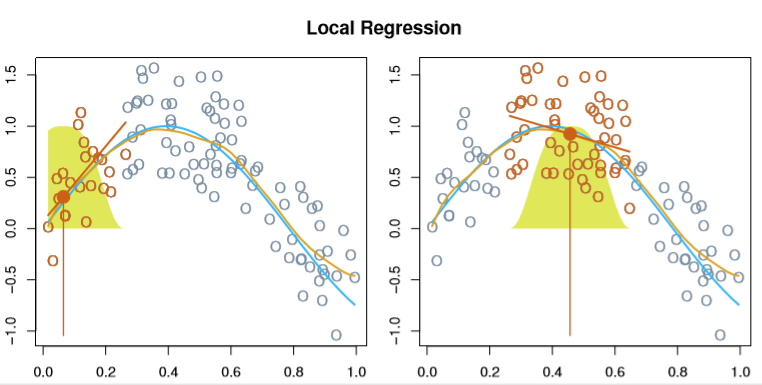

In [12]:
Image('images/fig_7_6.PNG')

Like KNN, the real trick is in selecting the sizing parameter, `s`-- if it's too large, the model will be flatter and more biased, too small and we'll see too much variance.

Additionally, this approach falls apart for high-dimensional data as the "closest neighbor points" becomes less and less practical to leverage.

## GAMs

Finally, we can further-genericize our formulation of the Basis Model

$y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2(x_i) + \beta_3 b_3(x_i) + ... + \beta_K b_K(x_i) + \epsilon_i$

to 

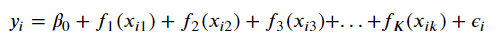

In [13]:
Image('images/gam_formula.PNG')

or 

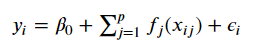

In [14]:
Image('images/gam_formula_reduced.PNG')

thus implicitly stripping out the `beta` terms with a series of *smooth* functions `f_j`, unique to each feature.

As far as training goes, GAMs often employ a method called *backfitting* that looks like

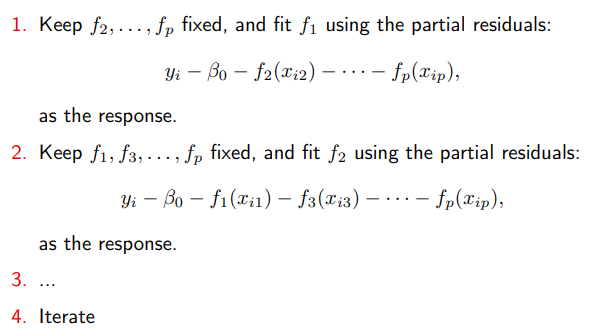

In [15]:
Image('images/backfitting.PNG')

Finally, the *additive* part of GAM allows us to examine the effects of our particular `X_j` term on `Y` for inference purposes, like so

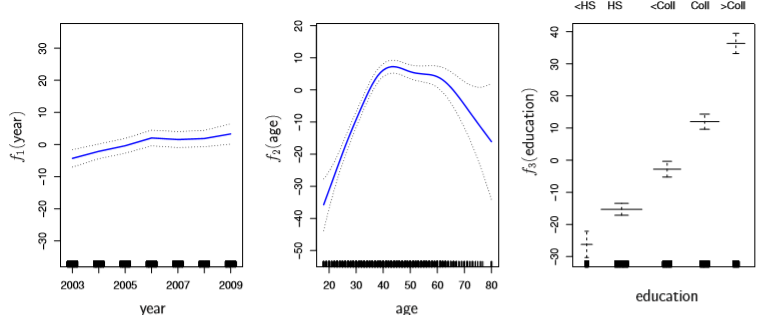

In [16]:
Image('images/fig_7_12.PNG')